#Algoritmos Evolutivos para Otimização de Hiperparâmetros de MLP em Python
Este notebook apresenta uma implementação prática de como Algoritmos Evolutivos (AEs) podem ser usados para otimizar os hiperparâmetros de um Multi-Layer Perceptron (MLP) utilizando as bibliotecas DEAP e scikit-learn. Abordaremos a teoria por trás da combinação dessas técnicas, a implementação do AE, o treinamento e avaliação do MLP, e a análise das métricas de desempenho e curvas de loss.


##1. Fundamentos Teóricos

###1.1 Algoritmos Evolutivos  
Algoritmos Evolutivos (AEs) são meta-heurísticas de otimização inspiradas na evolução biológica. Eles operam em uma população de indivíduos (soluções candidatas), que evoluem ao longo de gerações. Cada indivíduo é avaliado por uma função de aptidão (fitness function), que mede sua qualidade. Os indivíduos mais aptos são selecionados para a reprodução, onde operadores como crossover (recombinação) e mutação criam novos indivíduos, introduzindo variação na população. Esse processo iterativo busca otimizar a aptidão média da população, convergindo para soluções de alta qualidade.

###1.2 Multi-Layer Perceptron (MLP)
O Multi-Layer Perceptron (MLP) é uma classe de redes neurais feedforward, composta por uma camada de entrada, uma ou mais camadas ocultas e uma camada de saída. Cada neurônio em uma camada está conectado a todos os neurônios da camada seguinte. As conexões possuem pesos ajustáveis durante o treinamento através do algoritmo de retropropagação do erro. MLPs são capazes de aprender e modelar relações não lineares complexas em dados, tornando-os adequados para tarefas de classificação e regressão.

###1.3 Otimização de Hiperparâmetros com AEs
Os MLPs possuem hiperparâmetros que não são aprendidos durante o treinamento, mas que afetam drasticamente o desempenho do modelo. Exemplos incluem:

- Taxa de aprendizado (learning_rate_init): O quão rápido os pesos do modelo são atualizados.

- Número de épocas (max_iter): O número de vezes que o conjunto de dados completo é passado para o algoritmo de treinamento.

- Tamanho das camadas ocultas (hidden_layer_sizes): A arquitetura da rede neural (número de camadas e neurônios por camada).

- Função de ativação (activation): A função não linear aplicada à saída de cada neurônio.

- Tipo de otimizador (solver): O algoritmo usado para otimizar os pesos (ex: 'adam', 'sgd').

Tradicionalmente, a otimização desses hiperparâmetros é feita por busca em grade (grid search) ou busca aleatória (random search). No entanto, essas abordagens podem ser computacionalmente caras para espaços de busca grandes. AEs oferecem uma alternativa eficiente, explorando o espaço de hiperparâmetros de forma mais inteligente. Cada "indivíduo" no AE representa um conjunto específico de hiperparâmetros para o MLP. A "função de aptidão" avalia o desempenho do MLP com esses hiperparâmetros em um conjunto de validação.

###1.4 Métricas de Avaliação (Precision, Recall, F1-score)
Para problemas de classificação, especialmente com classes desbalanceadas, a acurácia pode ser enganosa. Métricas como Precisão, Recall e F1-score fornecem uma visão mais detalhada do desempenho do modelo:

- Verdadeiro Positivo (TP): Previsão correta da classe positiva.

- Verdadeiro Negativo (TN): Previsão correta da classe negativa.

- Falso Positivo (FP): Previsão da classe positiva, mas a real era negativa (erro tipo I).

- Falso Negativo (FN): Previsão da classe negativa, mas a real era positiva (erro tipo II).

Precisão (Precision): Proporção de previsões positivas que foram realmente corretas.
$$
Precision=\frac{TP}{FP+TP}
​$$

Uma alta precisão indica poucos falsos positivos.

Recall (Sensibilidade): Proporção de todas as instâncias positivas reais que foram corretamente identificadas.
$$
Recall=\frac{TP}{TP+FN}
$$
Um alto recall indica poucos falsos negativos.

F1-score: Média harmônica da Precisão e do Recall. É útil quando há um desequilíbrio entre Precisão e Recall ou quando as classes estão desbalanceadas.
$$
F1-score=2×\frac{Precision×Recall}{Precision+Recall}
$$
###1.5 Curvas de Loss
As curvas de loss (erro) durante o treinamento de uma rede neural são ferramentas visuais cruciais para diagnosticar o aprendizado do modelo.

- A loss de treinamento mostra o erro do modelo nos dados usados para o ajuste dos pesos.

- A loss de validação mostra o erro em um conjunto de dados separado, não visto durante o treinamento.

A análise dessas curvas ajuda a identificar:

- Overfitting (Sobreajuste): A loss de treinamento continua diminuindo, mas a loss de validação começa a aumentar. O modelo está memorizando o conjunto de treinamento.

- Underfitting (Subajuste): Ambas as losses permanecem altas, indicando que o modelo não está aprendendo os padrões dos dados.

- Convergência: Ambas as losses diminuem e se estabilizam, indicando que o modelo está aprendendo bem e generalizando.

##2. Preparação do Ambiente e Dados
###2.1 Instalação de Bibliotecas
Primeiro, vamos garantir que temos as bibliotecas necessárias instaladas.

In [ ]:
!pip install deap scikit-learn matplotlib

###2.2 Geração de Dados Sintéticos
Para demonstrar, geraremos um conjunto de dados sintético para um problema de classificação binária usando scikit-learn.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import warnings

# Suprimir avisos de convergência do MLPClassifier para o propósito de otimização
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Geração de dados sintéticos
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5,
                           n_classes=2, random_state=42)

# Divisão em conjuntos de treinamento, validação e teste
# Usamos validação para otimização de hiperparâmetros e teste para avaliação final

# Primeira divisão: separar conjunto de teste (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Segunda divisão: separar treinamento e validação do restante (80%)
# 0.25 de 0.8 = 0.2 do total para validação, 0.75 de 0.8 = 0.6 do total para treinamento
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Tamanho do conjunto de treinamento: {X_train.shape[0]}")
print(f"Tamanho do conjunto de validação: {X_val.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

# Verificar as proporções
total_samples = X.shape[0]
print(f"\nProporções:")
print(f"Treinamento: {X_train.shape[0]/total_samples:.1%}")
print(f"Validação: {X_val.shape[0]/total_samples:.1%}")
print(f"Teste: {X_test.shape[0]/total_samples:.1%}")

# Verificar balanceamento das classes
print(f"\nDistribuição das classes:")
print(f"Treinamento - Classe 0: {np.sum(y_train == 0)}, Classe 1: {np.sum(y_train == 1)}")
print(f"Validação - Classe 0: {np.sum(y_val == 0)}, Classe 1: {np.sum(y_val == 1)}")
print(f"Teste - Classe 0: {np.sum(y_test == 0)}, Classe 1: {np.sum(y_test == 1)}")

Tamanho do conjunto de treinamento: 600
Tamanho do conjunto de validação: 200
Tamanho do conjunto de teste: 200

Proporções:
Treinamento: 60.0%
Validação: 20.0%
Teste: 20.0%

Distribuição das classes:
Treinamento - Classe 0: 299, Classe 1: 301
Validação - Classe 0: 99, Classe 1: 101
Teste - Classe 0: 99, Classe 1: 101


##3. Implementação do Algoritmo Evolutivo
Vamos configurar o framework DEAP para otimizar os hiperparâmetros do MLPClassifier.

###3.1 Definição da Função de Aptidão (Fitness Function)
A função de aptidão é o coração do algoritmo evolutivo. Ela recebe um conjunto de hiperparâmetros, treina um MLP com esses parâmetros e retorna uma métrica de desempenho (neste caso, o F1-score) no conjunto de validação.

In [ ]:
def evaluate_mlp(individual):
    # Decodificar o indivíduo para hiperparâmetros do MLP
    # Exemplo: [learning_rate_idx, hidden_layer_size_idx, activation_idx, solver_idx, max_iter]

    # Mapeamento dos hiperparâmetros
    learning_rates = [0.1000, 0.001, 0.01, 0.1]
    hidden_layer_sizes_options = [(50,), (100,), (50, 50), (100, 50)] # Exemplos de arquiteturas
    activations = ['logistic', 'tanh', 'relu']
    solvers = ['adam', 'sgd']

    lr = learning_rates[individual[0]]
    hidden_layers = hidden_layer_sizes_options[individual[1]]
    activation_func = activations[individual[2]]
    solver_type = solvers[individual[3]]
    max_iterations = int(individual[4]) # Épocas

    # Criar e treinar o MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation_func,
        solver=solver_type,
        alpha=1e-5, # Regularização L2 padrão, pode ser otimizada também
        batch_size='auto',
        learning_rate_init=lr,
        max_iter=max_iterations,
        random_state=42,
        early_stopping=False, # Não usar early stopping aqui para que max_iter seja o fator limitante
        n_iter_no_change=10 # Parada antecipada suave, se não usar early_stopping=True
    )

    try:
        mlp.fit(X_train, y_train)

        # Capturar as losses de treinamento e validação se o solver for 'adam' ou 'sgd'
        # e se o MLP suportar partial_fit (não é o caso do scikit-learn MLPClassifier para loss history)
        # Para coletar losses de treino e validação por época, precisaríamos de uma implementação customizada
        # ou ajustar o 'max_iter' para ser pequeno e chamar `partial_fit` manualmente, o que não é ideal aqui.
        # Por simplicidade e como o MLPClassifier não expõe diretamente o histórico de loss por época para validação,
        # vamos treinar e predizer normalmente.
        # A coleta das curvas de loss será feita com o melhor modelo encontrado no final.

        y_pred = mlp.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        return f1,
    except Exception as e:
        # Se ocorrer algum erro durante o treinamento (ex: gradientes explosivos com LR muito alta),
        # retornar aptidão baixa para penalizar esse conjunto de hiperparâmetros.
        print(f"Erro ao treinar MLP com hiperparâmetros {individual}: {e}")
        return 0.0, # Retorna 0.0 para aptidão muito baixa

###3.2 Configuração do DEAP
Agora vamos configurar o `DEAP` para o nosso problema de otimização.

In [ ]:
# Definir o tipo de Aptidão: maximizar o F1-score
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Definir o Indivíduo: lista de inteiros representando os índices dos hiperparâmetros
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Atributos: Geradores de valores para cada hiperparâmetro
# learning_rate_init: [0, 1, 2, 3] para [0.0001, 0.001, 0.01, 0.1]
toolbox.register("attr_lr", random.randint, 0, 3)
# hidden_layer_sizes: [0, 1, 2, 3] para [(50,), (100,), (50, 50), (100, 50)]
toolbox.register("attr_hidden_layers", random.randint, 0, 3)
# activation: [0, 1, 2] para ['logistic', 'tanh', 'relu']
toolbox.register("attr_activation", random.randint, 0, 2)
# solver: [0, 1] para ['adam', 'sgd']
toolbox.register("attr_solver", random.randint, 0, 1)
# max_iter: [50, 500] (número de épocas)
toolbox.register("attr_max_iter", random.randint, 50, 500)

# Estrutura do Indivíduo: uma combinação dos atributos
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lr,
                  toolbox.attr_hidden_layers,
                  toolbox.attr_activation,
                  toolbox.attr_solver,
                  toolbox.attr_max_iter),
                 n=1) # n=1 significa que cada indivíduo é uma lista de um conjunto desses atributos

# Estrutura da População
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operadores Genéticos
toolbox.register("evaluate", evaluate_mlp)
toolbox.register("mate", tools.cxTwoPoint) # Crossover de dois pontos
toolbox.register("mutate", tools.mutUniformInt, low=[0, 0, 0, 0, 50], up=[3, 3, 2, 1, 500], indpb=0.1) # Mutação uniforme
toolbox.register("select", tools.selTournament, tournsize=3) # Seleção por torneio

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


###3.3 Execução do Algoritmo Genético
Vamos executar o algoritmo genético e registrar as estatísticas do processo evolutivo.

gen	nevals	avg     	std      	min     	max     
0  	50    	0.936027	0.0480973	0.623762	0.969697
1  	38    	0.948361	0.0200699	0.873786	0.969697
2  	43    	0.960189	0.0123143	0.9     	0.969697
3  	32    	0.965535	0.00716396	0.941176	0.969697
4  	39    	0.964126	0.0127724 	0.897561	0.969697
5  	41    	0.966608	0.00752689	0.941176	0.969697
6  	26    	0.966451	0.00812693	0.936585	0.969697
7  	39    	0.967554	0.00663548	0.936585	0.969697
8  	37    	0.966518	0.00884226	0.921569	0.969697
9  	38    	0.96505 	0.00951118	0.932039	0.969697
10 	41    	0.967623	0.00538005	0.94898 	0.969697
11 	41    	0.967283	0.00709345	0.941176	0.969697
12 	36    	0.969099	0.00311215	0.949495	0.969697
13 	39    	0.968247	0.00551317	0.943005	0.969697
14 	35    	0.9696  	0.000682199	0.964824	0.969697
15 	35    	0.969199	0.00294714 	0.94898 	0.969697
16 	34    	0.967795	0.00567281 	0.94898 	0.969697
17 	36    	0.969283	0.00290043 	0.94898 	0.969697
18 	42    	0.969088	0.00302701 	0.94898 	0.969697
19 	39    	0.969226

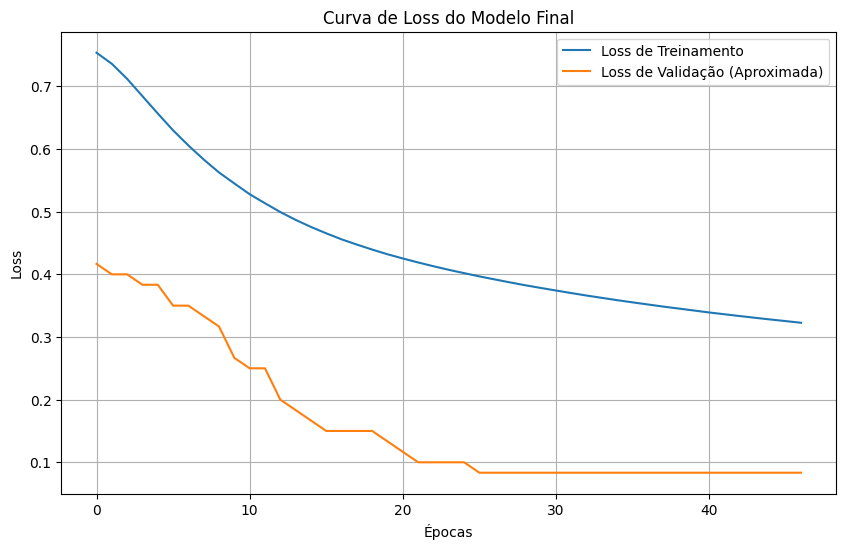

In [ ]:
def main_evolution():
    pop = toolbox.population(n=50) # População inicial de 50 indivíduos
    hof = tools.HallOfFame(1) # Armazena o melhor indivíduo encontrado
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Executa o algoritmo genético simples
    # CXPB: Probabilidade de crossover
    # MUTPB: Probabilidade de mutação
    # NGEN: Número de gerações
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=50,
                                   stats=stats, halloffame=hof, verbose=True)

    return pop, log, hof

if __name__ == "__main__":
    pop, log, hof = main_evolution()

    # Melhor indivíduo (conjunto de hiperparâmetros)
    best_individual = hof[0]
    print("\nMelhor Indivíduo (Hiperparâmetros Codificados):", best_individual)

    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    hidden_layer_sizes_options = [(50,), (100,), (50, 50), (100, 50)]
    activations = ['logistic', 'tanh', 'relu']
    solvers = ['adam', 'sgd']

    best_lr = learning_rates[best_individual[0]]
    best_hidden_layers = hidden_layer_sizes_options[best_individual[1]]
    best_activation = activations[best_individual[2]]
    best_solver = solvers[best_individual[3]]
    best_max_iter = int(best_individual[4])

    print(f"\nMelhores Hiperparâmetros Encontrados:")
    print(f"  Taxa de Aprendizado (learning_rate_init): {best_lr}")
    print(f"  Tamanho das Camadas Ocultas (hidden_layer_sizes): {best_hidden_layers}")
    print(f"  Função de Ativação (activation): {best_activation}")
    print(f"  Otimizador (solver): {best_solver}")
    print(f"  Número de Épocas (max_iter): {best_max_iter}")
    print(f"  F1-score de Validação (Melhor): {hof[0].fitness.values[0]:.4f}")

    # Treinar o MLP final com os melhores hiperparâmetros e coletar a loss history
    final_mlp = MLPClassifier(
        hidden_layer_sizes=best_hidden_layers,
        activation=best_activation,
        solver=best_solver,
        alpha=1e-5,
        batch_size='auto',
        learning_rate_init=best_lr,
        max_iter=best_max_iter,
        random_state=42,
        early_stopping=True, # Agora podemos usar early stopping para o modelo final para evitar overfitting
        n_iter_no_change=20, # Aumentar para ser menos sensível
        validation_fraction=0.1 # Fração dos dados de treino para early stopping
    )
    final_mlp.fit(X_train, y_train)

    # Avaliar o modelo final no conjunto de teste
    y_pred_test = final_mlp.predict(X_test)
    f1_final = f1_score(y_test, y_pred_test)
    precision_final = precision_score(y_test, y_pred_test)
    recall_final = recall_score(y_test, y_pred_test)

    print(f"\nResultados do Modelo Final no Conjunto de Teste:")
    print(f"  F1-score: {f1_final:.4f}")
    print(f"  Precisão: {precision_final:.4f}")
    print(f"  Recall: {recall_final:.4f}")

    # Coletar as curvas de loss (o scikit-learn MLPClassifier armazena apenas a loss de treinamento)
    # Para a loss de validação, seria necessário uma abordagem de loop manual ou outra biblioteca (TensorFlow/Keras).
    # Aqui, `loss_curve_` é a loss de treinamento. Se `early_stopping=True`, o `validation_scores_` também estará disponível.
    if hasattr(final_mlp, 'loss_curve_'):
        plt.figure(figsize=(10, 6))
        plt.plot(final_mlp.loss_curve_, label='Loss de Treinamento')
        if hasattr(final_mlp, 'validation_scores_'):
             # Ajustar validation_scores_ para ser loss, não score
            val_loss = [1 - score for score in final_mlp.validation_scores_] # Aproximação se score for acurácia
            plt.plot(val_loss, label='Loss de Validação (Aproximada)') # Aproximação baseada em score, se score é acurácia
        plt.title('Curva de Loss do Modelo Final')
        plt.xlabel('Épocas')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

##4. Análise de Resultados
Após a execução do algoritmo genético, o `hof` (Hall of Fame) conterá o melhor indivíduo encontrado, que corresponde ao conjunto de hiperparâmetros que resultou no maior **F1-score** no conjunto de validação.

###4.1 Melhores Hiperparâmetros
A saída do `print` na seção anterior mostrará os melhores hiperparâmetros decodificados que o algoritmo evolutivo encontrou. Essa é a combinação de `learning_rate_init`, `hidden_layer_sizes`, `activation`, `solver` e `max_iter` que otimizou o desempenho do MLP no conjunto de validação.

###4.2 Métricas de Desempenho
O modelo final, treinado com os hiperparâmetros otimizados, é então avaliado no **conjunto de teste**. É crucial usar o conjunto de teste para a avaliação final, pois ele representa dados completamente novos que o modelo nunca viu, fornecendo uma estimativa imparcial de sua capacidade de generalização. As métricas de **F1-score**, **Precisão** e **Recall** são apresentadas para o conjunto de teste, dando uma visão abrangente do desempenho do classificador.

###4.3 Curvas de Loss
O gráfico das Curvas de Loss (Treinamento vs. Validação) ilustra como o erro do modelo se comporta ao longo das épocas de treinamento.

- A loss de treinamento geralmente diminui constantemente.

- A loss de validação deve seguir uma tendência similar. Se ela começar a subir enquanto a loss de treinamento continua a cair, é um forte indicativo de overfitting.

- No `scikit-learn's MLPClassifier`, o atributo `loss_curve_` armazena a loss de treinamento. Se `early_stopping=True` foi usado, `validation_scores_` armazena o score (e.g., acurácia) na validação. Para visualizar a loss de validação, precisamos converter o score em loss (e.g., `1 - acurácia`).



##5. Conclusão
Este notebook demonstrou como algoritmos evolutivos, especificamente um algoritmo genético implementado com `DEAP`, podem ser eficazmente utilizados para otimizar os hiperparâmetros de um `MLPClassifier` do `scikit-learn`. Essa abordagem permite uma busca mais inteligente no espaço de hiperparâmetros em comparação com métodos exaustivos, potencialmente levando a modelos com melhor desempenho e generalização.

A importância de utilizar métricas de avaliação robustas como F1-score, Precisão e Recall, e a análise das curvas de loss, foi destacada para garantir uma compreensão completa do desempenho do modelo e para diagnosticar problemas como overfitting.

Embora o custo computacional possa ser uma preocupação, a capacidade dos AEs de explorar espaços de busca complexos torna-os uma ferramenta valiosa no kit de ferramentas de otimização de machine learning, especialmente para problemas onde a escolha manual ou por busca exaustiva de hiperparâmetros é inviável.

###5.1 Configuração dos Experimentos

In [ ]:

import time
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração dos experimentos
experimentos_config = {
    'Baseline': {
        'use_ga': False,
        'pop_size': None,
        'ngen': None,
        'cxpb': None,
        'mutpb': None,
        'description': 'Parâmetros padrão do MLPClassifier'
    },
    'GA_Config1': {
        'use_ga': True,
        'pop_size': 30,
        'ngen': 25,
        'cxpb': 0.7,
        'mutpb': 0.2,
        'description': 'População pequena, poucas gerações'
    },
    'GA_Config2': {
        'use_ga': True,
        'pop_size': 50,
        'ngen': 50,
        'cxpb': 0.7,
        'mutpb': 0.2,
        'description': 'População média, gerações médias'
    },
    'GA_Config3': {
        'use_ga': True,
        'pop_size': 70,
        'ngen': 40,
        'cxpb': 0.8,
        'mutpb': 0.15,
        'description': 'População grande, alta taxa de crossover'
    },
    'GA_Config4': {
        'use_ga': True,
        'pop_size': 40,
        'ngen': 60,
        'cxpb': 0.6,
        'mutpb': 0.3,
        'description': 'Alta taxa de mutação, mais gerações'
    }
}

# Exibir tabela de configurações
config_df = pd.DataFrame({
    'Experimento': list(experimentos_config.keys()),
    'População': [cfg['pop_size'] for cfg in experimentos_config.values()],
    'Gerações': [cfg['ngen'] for cfg in experimentos_config.values()],
    'Taxa Crossover': [cfg['cxpb'] for cfg in experimentos_config.values()],
    'Taxa Mutação': [cfg['mutpb'] for cfg in experimentos_config.values()],
    'Descrição': [cfg['description'] for cfg in experimentos_config.values()]
})

print("Tabela de Configurações dos Experimentos:")
print(config_df.to_string(index=False))

Tabela de Configurações dos Experimentos:
Experimento  População  Gerações  Taxa Crossover  Taxa Mutação                                Descrição
   Baseline        NaN       NaN             NaN           NaN       Parâmetros padrão do MLPClassifier
 GA_Config1       30.0      25.0             0.7          0.20       População pequena, poucas gerações
 GA_Config2       50.0      50.0             0.7          0.20         População média, gerações médias
 GA_Config3       70.0      40.0             0.8          0.15 População grande, alta taxa de crossover
 GA_Config4       40.0      60.0             0.6          0.30      Alta taxa de mutação, mais gerações


###5.2 Implementação do Baseline e Funções de Teste

In [ ]:
def baseline_mlp():
    """Executa o baseline com parâmetros padrão do MLPClassifier"""
    start_time = time.time()

    # MLPClassifier com parâmetros padrão
    baseline_model = MLPClassifier(
        random_state=42,
        max_iter=200  # Limitar para comparação justa
    )

    baseline_model.fit(X_train, y_train)
    y_pred_val = baseline_model.predict(X_val)
    y_pred_test = baseline_model.predict(X_test)

    # Métricas
    f1_val = f1_score(y_val, y_pred_val)
    f1_test = f1_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)

    execution_time = time.time() - start_time

    return {
        'f1_validation': f1_val,
        'f1_test': f1_test,
        'precision_test': precision_test,
        'recall_test': recall_test,
        'execution_time': execution_time,
        'best_params': {
            'learning_rate_init': 0.001,  # padrão
            'hidden_layer_sizes': (100,),  # padrão
            'activation': 'relu',  # padrão
            'solver': 'adam',  # padrão
            'max_iter': 200
        },
        'fitness_history': None
    }

def run_ga_experiment(pop_size, ngen, cxpb, mutpb):
    """Executa um experimento com algoritmo genético"""
    start_time = time.time()

    # Reconfigurar o DEAP para este experimento
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox_exp = base.Toolbox()

    # Registrar atributos e operadores
    toolbox_exp.register("attr_lr", random.randint, 0, 3)
    toolbox_exp.register("attr_hidden_layers", random.randint, 0, 3)
    toolbox_exp.register("attr_activation", random.randint, 0, 2)
    toolbox_exp.register("attr_solver", random.randint, 0, 1)
    toolbox_exp.register("attr_max_iter", random.randint, 50, 300)

    toolbox_exp.register("individual", tools.initCycle, creator.Individual,
                        (toolbox_exp.attr_lr,
                         toolbox_exp.attr_hidden_layers,
                         toolbox_exp.attr_activation,
                         toolbox_exp.attr_solver,
                         toolbox_exp.attr_max_iter), n=1)

    toolbox_exp.register("population", tools.initRepeat, list, toolbox_exp.individual)
    toolbox_exp.register("evaluate", evaluate_mlp)
    toolbox_exp.register("mate", tools.cxTwoPoint)
    toolbox_exp.register("mutate", tools.mutUniformInt,
                        low=[0, 0, 0, 0, 50], up=[3, 3, 2, 1, 300], indpb=0.1)
    toolbox_exp.register("select", tools.selTournament, tournsize=3)

    # Executar algoritmo genético
    pop = toolbox_exp.population(n=pop_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox_exp, cxpb=cxpb, mutpb=mutpb,
                                  ngen=ngen, stats=stats, halloffame=hof, verbose=False)

    # Decodificar melhor indivíduo
    best_individual = hof[0]
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    hidden_layer_sizes_options = [(50,), (100,), (50, 50), (100, 50)]
    activations = ['logistic', 'tanh', 'relu']
    solvers = ['adam', 'sgd']

    best_lr = learning_rates[best_individual[0]]
    best_hidden_layers = hidden_layer_sizes_options[best_individual[1]]
    best_activation = activations[best_individual[2]]
    best_solver = solvers[best_individual[3]]
    best_max_iter = int(best_individual[4])

    # Treinar modelo final com melhores parâmetros
    final_model = MLPClassifier(
        hidden_layer_sizes=best_hidden_layers,
        activation=best_activation,
        solver=best_solver,
        alpha=1e-5,
        learning_rate_init=best_lr,
        max_iter=best_max_iter,
        random_state=42
    )

    final_model.fit(X_train, y_train)
    y_pred_val = final_model.predict(X_val)
    y_pred_test = final_model.predict(X_test)

    # Métricas
    f1_val = f1_score(y_val, y_pred_val)
    f1_test = f1_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)

    execution_time = time.time() - start_time

    return {
        'f1_validation': f1_val,
        'f1_test': f1_test,
        'precision_test': precision_test,
        'recall_test': recall_test,
        'execution_time': execution_time,
        'best_params': {
            'learning_rate_init': best_lr,
            'hidden_layer_sizes': best_hidden_layers,
            'activation': best_activation,
            'solver': best_solver,
            'max_iter': best_max_iter
        },
        'fitness_history': log,
        'best_fitness': best_individual.fitness.values[0]
    }

###5.3 Execução dos Experimentos

In [ ]:
# Executar todos os experimentos
print("Executando experimentos...")
resultados = {}

for exp_name, config in experimentos_config.items():
    print(f"\nExecutando {exp_name}...")

    if not config['use_ga']:
        # Baseline
        resultado = baseline_mlp()
    else:
        # Algoritmo Genético
        resultado = run_ga_experiment(
            pop_size=config['pop_size'],
            ngen=config['ngen'],
            cxpb=config['cxpb'],
            mutpb=config['mutpb']
        )

    resultados[exp_name] = resultado
    print(f"F1-score (teste): {resultado['f1_test']:.4f}")
    print(f"Tempo de execução: {resultado['execution_time']:.2f}s")

print("\nTodos os experimentos concluídos!")

Executando experimentos...

Executando Baseline...
F1-score (teste): 0.9463
Tempo de execução: 0.49s

Executando GA_Config1...
F1-score (teste): 0.9557
Tempo de execução: 199.03s

Executando GA_Config2...
F1-score (teste): 0.7451
Tempo de execução: 480.92s

Executando GA_Config3...
F1-score (teste): 0.7905
Tempo de execução: 647.08s

Executando GA_Config4...
F1-score (teste): 0.8318
Tempo de execução: 532.97s

Todos os experimentos concluídos!


###5.4 Análise de Resultados

In [ ]:
# Criar tabela de resultados
resultados_df = pd.DataFrame({
    'Experimento': list(resultados.keys()),
    'População': [experimentos_config[exp]['pop_size'] for exp in resultados.keys()],
    'Gerações': [experimentos_config[exp]['ngen'] for exp in resultados.keys()],
    'Taxa Mutação': [experimentos_config[exp]['mutpb'] for exp in resultados.keys()],
    'Taxa Crossover': [experimentos_config[exp]['cxpb'] for exp in resultados.keys()],
    'Learning Rate': [resultados[exp]['best_params']['learning_rate_init'] for exp in resultados.keys()],
    'F1-Score (Val)': [resultados[exp]['f1_validation'] for exp in resultados.keys()],
    'F1-Score (Test)': [resultados[exp]['f1_test'] for exp in resultados.keys()],
    'Precisão (Test)': [resultados[exp]['precision_test'] for exp in resultados.keys()],
    'Recall (Test)': [resultados[exp]['recall_test'] for exp in resultados.keys()],
    'Tempo (s)': [resultados[exp]['execution_time'] for exp in resultados.keys()]
})

print("Tabela de Resultados dos Experimentos:")
print(resultados_df.round(4).to_string(index=False))

Tabela de Resultados dos Experimentos:
Experimento  População  Gerações  Taxa Mutação  Taxa Crossover  Learning Rate  F1-Score (Val)  F1-Score (Test)  Precisão (Test)  Recall (Test)  Tempo (s)
   Baseline        NaN       NaN           NaN             NaN         0.0010          0.9548           0.9463           0.9327         0.9604     0.4950
 GA_Config1       30.0      25.0          0.20             0.7         0.1000          0.9697           0.9557           0.9510         0.9604   199.0338
 GA_Config2       50.0      50.0          0.20             0.7         0.0001          0.7590           0.7451           0.7379         0.7525   480.9207
 GA_Config3       70.0      40.0          0.15             0.8         0.0001          0.8333           0.7905           0.7615         0.8218   647.0771
 GA_Config4       40.0      60.0          0.30             0.6         0.0001          0.8517           0.8318           0.7876         0.8812   532.9725


###5.5 Visualizações

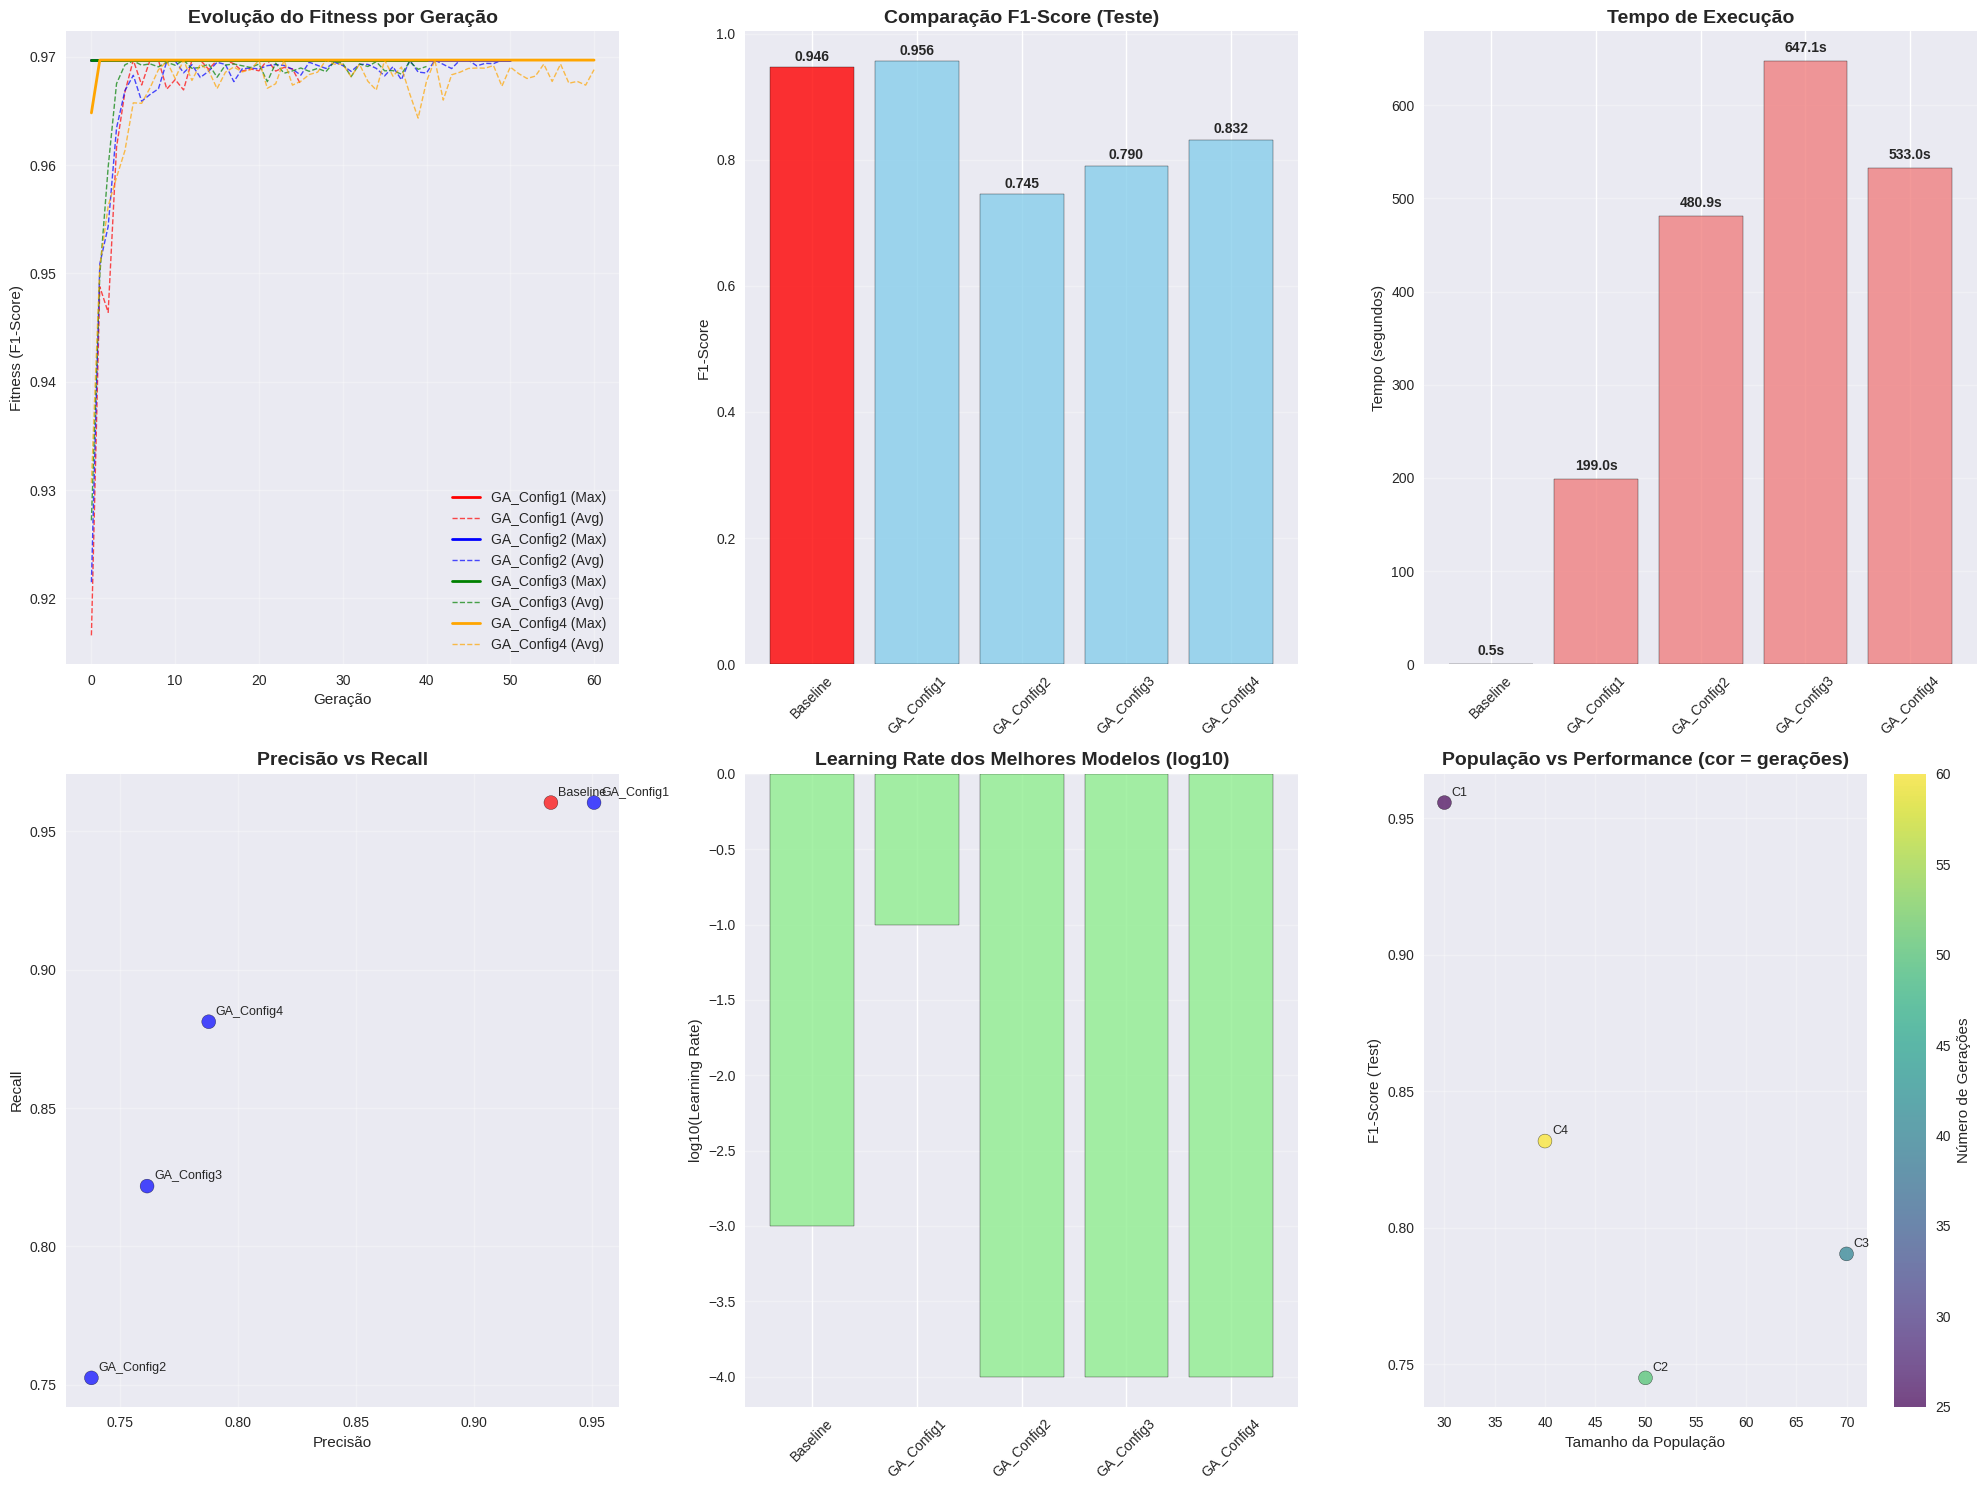

In [ ]:
# Configurar o estilo dos gráficos
plt.style.use('seaborn-v0_8')
fig = plt.figure(figsize=(20, 15))

# 1. Fitness por geração para experimentos GA
plt.subplot(2, 3, 1)
colors = ['red', 'blue', 'green', 'orange']
ga_experiments = [exp for exp in resultados.keys() if exp != 'Baseline']

for i, exp_name in enumerate(ga_experiments):
    if resultados[exp_name]['fitness_history']:
        generations = range(len(resultados[exp_name]['fitness_history']))
        max_fitness = [record['max'] for record in resultados[exp_name]['fitness_history']]
        avg_fitness = [record['avg'] for record in resultados[exp_name]['fitness_history']]

        plt.plot(generations, max_fitness, color=colors[i], linewidth=2,
                label=f'{exp_name} (Max)', linestyle='-')
        plt.plot(generations, avg_fitness, color=colors[i], linewidth=1,
                label=f'{exp_name} (Avg)', linestyle='--', alpha=0.7)

plt.title('Evolução do Fitness por Geração', fontsize=14, fontweight='bold')
plt.xlabel('Geração')
plt.ylabel('Fitness (F1-Score)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Comparação F1-Score
plt.subplot(2, 3, 2)
experimentos = resultados_df['Experimento']
f1_scores = resultados_df['F1-Score (Test)']
colors_bar = ['red' if exp == 'Baseline' else 'skyblue' for exp in experimentos]

bars = plt.bar(experimentos, f1_scores, color=colors_bar, alpha=0.8, edgecolor='black')
plt.title('Comparação F1-Score (Teste)', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Tempo de execução
plt.subplot(2, 3, 3)
tempos = resultados_df['Tempo (s)']
bars = plt.bar(experimentos, tempos, color='lightcoral', alpha=0.8, edgecolor='black')
plt.title('Tempo de Execução', fontsize=14, fontweight='bold')
plt.ylabel('Tempo (segundos)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar, tempo in zip(bars, tempos):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(tempos)*0.01,
             f'{tempo:.1f}s', ha='center', va='bottom', fontweight='bold')

# 4. Comparação Precisão vs Recall
plt.subplot(2, 3, 4)
precisao = resultados_df['Precisão (Test)']
recall = resultados_df['Recall (Test)']

scatter_colors = ['red' if exp == 'Baseline' else 'blue' for exp in experimentos]
plt.scatter(precisao, recall, c=scatter_colors, s=100, alpha=0.7, edgecolors='black')

for i, exp in enumerate(experimentos):
    plt.annotate(exp, (precisao[i], recall[i]), xytext=(5, 5),
                textcoords='offset points', fontsize=9)

plt.title('Precisão vs Recall', fontsize=14, fontweight='bold')
plt.xlabel('Precisão')
plt.ylabel('Recall')
plt.grid(True, alpha=0.3)

# 5. Parâmetros dos melhores modelos
plt.subplot(2, 3, 5)
learning_rates = [resultados[exp]['best_params']['learning_rate_init'] for exp in experimentos]
learning_rates_log = [np.log10(lr) for lr in learning_rates]

bars = plt.bar(experimentos, learning_rates_log, color='lightgreen', alpha=0.8, edgecolor='black')
plt.title('Learning Rate dos Melhores Modelos (log10)', fontsize=14, fontweight='bold')
plt.ylabel('log10(Learning Rate)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# 6. Análise populacional vs performance
plt.subplot(2, 3, 6)
ga_only = resultados_df[resultados_df['Experimento'] != 'Baseline']
if not ga_only.empty:
    plt.scatter(ga_only['População'], ga_only['F1-Score (Test)'],
               c=ga_only['Gerações'], s=100, alpha=0.7, cmap='viridis', edgecolors='black')
    plt.colorbar(label='Número de Gerações')

    for i, exp in enumerate(ga_only['Experimento']):
        plt.annotate(exp.replace('GA_Config', 'C'),
                    (ga_only['População'].iloc[i], ga_only['F1-Score (Test)'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('População vs Performance (cor = gerações)', fontsize=14, fontweight='bold')
plt.xlabel('Tamanho da População')
plt.ylabel('F1-Score (Test)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()